In [1]:
%load_ext autoreload
%autoreload 2

from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from model_modules import *
from data_modules import *


plt.style.use('science')

In [2]:
def load_ckpt(model_class, run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = model_class.load_from_checkpoint(ckpt_path)
    return model


models = [
    # [CDMA_Net, "gjoxavfa", "cdma_epoch=430-step=38790-val_loss=0.00.ckpt"],
    [CNNAEAttention, "p3fky56w", "cnn_ae_att_epoch=208-step=18810-val_loss=0.03.ckpt"],
    [LinearAE, "qnz17vpr", "linear_ae_epoch=103-step=9360-val_loss=0.02.ckpt"],
    [LinearVAE, "bkvapq2t", "linear_vae_epoch=386-step=34830-val_loss=0.02.ckpt"],
    [CNNAE, "wtgwzqaa", "cnn_ae_epoch=115-step=10440-val_loss=0.02.ckpt"],
    [CNNVAE, "dqho97xp", "cnn_vae_epoch=223-step=20160-val_acc=0.02.ckpt"],
    # [TransformerAE, "ish762qv", "transformer_ae_epoch=320-step=28890-val_acc=0.00.ckpt"],
    [TransformerAE, "e4didim2", "transformer_ae_epoch=86-step=7830-val_loss=0.00.ckpt"],
    [TransformerVAE, "qxmwpa49", "transformer_vae_epoch=235-step=21240-val_acc=0.03.ckpt"],
]

In [3]:
data_module = BaseDataModule(batch_size=128)
data_module.prepare_data()
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
print(test_loader)

In [4]:
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def test_model(model, test_loader):
    model.eval()
    reconstruction_errors = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].cpu().numpy()

            # Forward pass
            if isinstance(model, AE):
                recon_signal, recon_spectrum = model(signal, spectrum)
            elif isinstance(model, VAE):
                recon_signal, recon_spectrum, _, _ = model(signal, spectrum)
            else:
                raise ValueError("Model must be an instance of AE or VAE")

            # Calculate combined reconstruction error
            error_signal = torch.mean(
                (recon_signal - signal) ** 2, dim=[1, 2]).cpu().numpy()
            error_spectrum = torch.mean(
                (recon_spectrum - spectrum) ** 2, dim=[1, 2]).cpu().numpy()
            total_error = error_signal + error_spectrum
            print(total_error)
            reconstruction_errors.extend(total_error)
            all_true_labels.extend(labels)

    reconstruction_errors = np.array(reconstruction_errors)
    all_true_labels = np.array(all_true_labels)

    # Compute beta_0 using test errors instead of training errors
    mean_test_error = np.mean(reconstruction_errors)
    std_test_error = np.std(reconstruction_errors)
    print(f"{model.__class__.__name__} - Mean test error: {mean_test_error:.4f}, Std test error: {std_test_error:.4f}")
    # threshold = mean_test_error + 5 * std_test_error
    threshold = np.percentile(reconstruction_errors, 60)

    # Predict based on the new threshold
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(all_true_labels, reconstruction_errors)
    roc_auc_val = auc(fpr, tpr)

    num_params = count_parameters(model)

    return {
        'reconstruction_errors': reconstruction_errors,
        'predicted_labels': predicted_labels,
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'confusion_matrix': confusion_matrix(all_true_labels, predicted_labels),
        'classification_report': classification_report(all_true_labels, predicted_labels,
                                                       target_names=['Interference-free', 'Interference'], digits=6),
        'num_params': num_params
    }

In [6]:
results = {}
for model_class, run_name, file_name in models:
    model = load_ckpt(model_class, run_name, file_name)
    results[model.__class__.__name__] = test_model(model, test_loader)

[0.06392282 0.04611702 0.09669597 0.04942244 0.06140171 0.05068742
 0.10888141 0.06332622 0.04793574 0.07287452 0.07327051 0.07557127
 0.04925614 0.05360451 0.09609787 0.10347369 0.0574819  0.05559393
 0.04775209 0.04728121 0.11883969 0.0826295  0.04997231 0.08773495
 0.04784063 0.05215894 0.05478446 0.1120762  0.07348417 0.06010589
 0.05227806 0.0500107  0.0842044  0.05975987 0.1134391  0.0517077
 0.04998427 0.1094237  0.05218802 0.04867992 0.05650129 0.05861675
 0.06822373 0.06059515 0.08578262 0.05072953 0.0493817  0.0701985
 0.04875303 0.05740381 0.05983155 0.05188349 0.05020899 0.05267471
 0.05798771 0.04700188 0.04821455 0.0541154  0.05329578 0.04713423
 0.10685501 0.04780169 0.0805769  0.04664994 0.09083155 0.07933701
 0.05110243 0.04837388 0.05131974 0.04700357 0.05202259 0.07373918
 0.10787204 0.06615742 0.10064834 0.04720947 0.05134267 0.05009453
 0.07003793 0.048248   0.05251783 0.07867716 0.1011707  0.04889174
 0.07828204 0.05962365 0.06154253 0.0620581  0.05036217 0.051272

/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[1.30967746e-04 1.46952341e-04 1.69395571e-04 1.03839229e-04
 1.32355868e-04 1.17121745e-04 2.56981613e-04 1.26470171e-04
 1.15845956e-04 1.92328938e-04 1.52253415e-04 2.40052264e-04
 1.35478665e-04 1.01995814e-04 1.76306581e-04 1.96739798e-04
 1.41311946e-04 1.59378164e-04 1.23140082e-04 1.74472516e-04
 2.14692584e-04 1.63667370e-04 1.88289283e-04 1.63000033e-04
 1.41569952e-04 1.29085704e-04 1.05593499e-04 1.78098504e-04
 1.40223929e-04 1.10737863e-04 1.13832633e-04 1.15488670e-04
 1.58424271e-04 1.23926628e-04 2.23716124e-04 1.18587886e-04
 1.24899496e-04 2.17152075e-04 1.10422734e-04 1.56934941e-04
 1.27436651e-04 1.36154762e-04 1.43593672e-04 1.05777668e-04
 1.28945234e-04 1.37935713e-04 9.31250979e-05 1.42515055e-04
 1.02086145e-04 1.24863829e-04 1.60912910e-04 1.47216386e-04
 1.14158436e-04 1.04199120e-04 1.73553781e-04 1.44595280e-04
 1.10463217e-04 1.68611048e-04 1.19747434e-04 1.27074032e-04
 2.45925185e-04 1.30177781e-04 1.46519713e-04 1.22276164e-04
 2.36330452e-04 8.615152

/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[0.02808277 0.02430611 0.06225754 0.02780249 0.0227428  0.02148565
 0.06353837 0.02515663 0.02130814 0.03263185 0.02916986 0.03213457
 0.01803212 0.02479865 0.04432676 0.05109553 0.02094518 0.02058854
 0.02155543 0.02341882 0.05369567 0.03781602 0.01888217 0.04533227
 0.01885351 0.0193509  0.01685599 0.07441249 0.02957876 0.02414912
 0.02132343 0.01658032 0.03589101 0.02365622 0.06674168 0.02169419
 0.02207257 0.05840222 0.01921226 0.02283935 0.02009871 0.02250214
 0.02796042 0.02170978 0.04052825 0.01954083 0.01808856 0.02537371
 0.02162276 0.01949169 0.02185768 0.01777135 0.02022005 0.02108647
 0.02385557 0.0285942  0.01868998 0.01833637 0.02111808 0.02272046
 0.04635827 0.02385913 0.03175469 0.0173577  0.04449068 0.0453711
 0.02420983 0.01932814 0.0193009  0.0200264  0.02012931 0.03067877
 0.05420429 0.02423508 0.04606604 0.01492531 0.02140607 0.01988041
 0.02644341 0.02067969 0.02100041 0.02821732 0.05646221 0.01991772
 0.03445331 0.02099428 0.02542201 0.02170781 0.01936171 0.02121

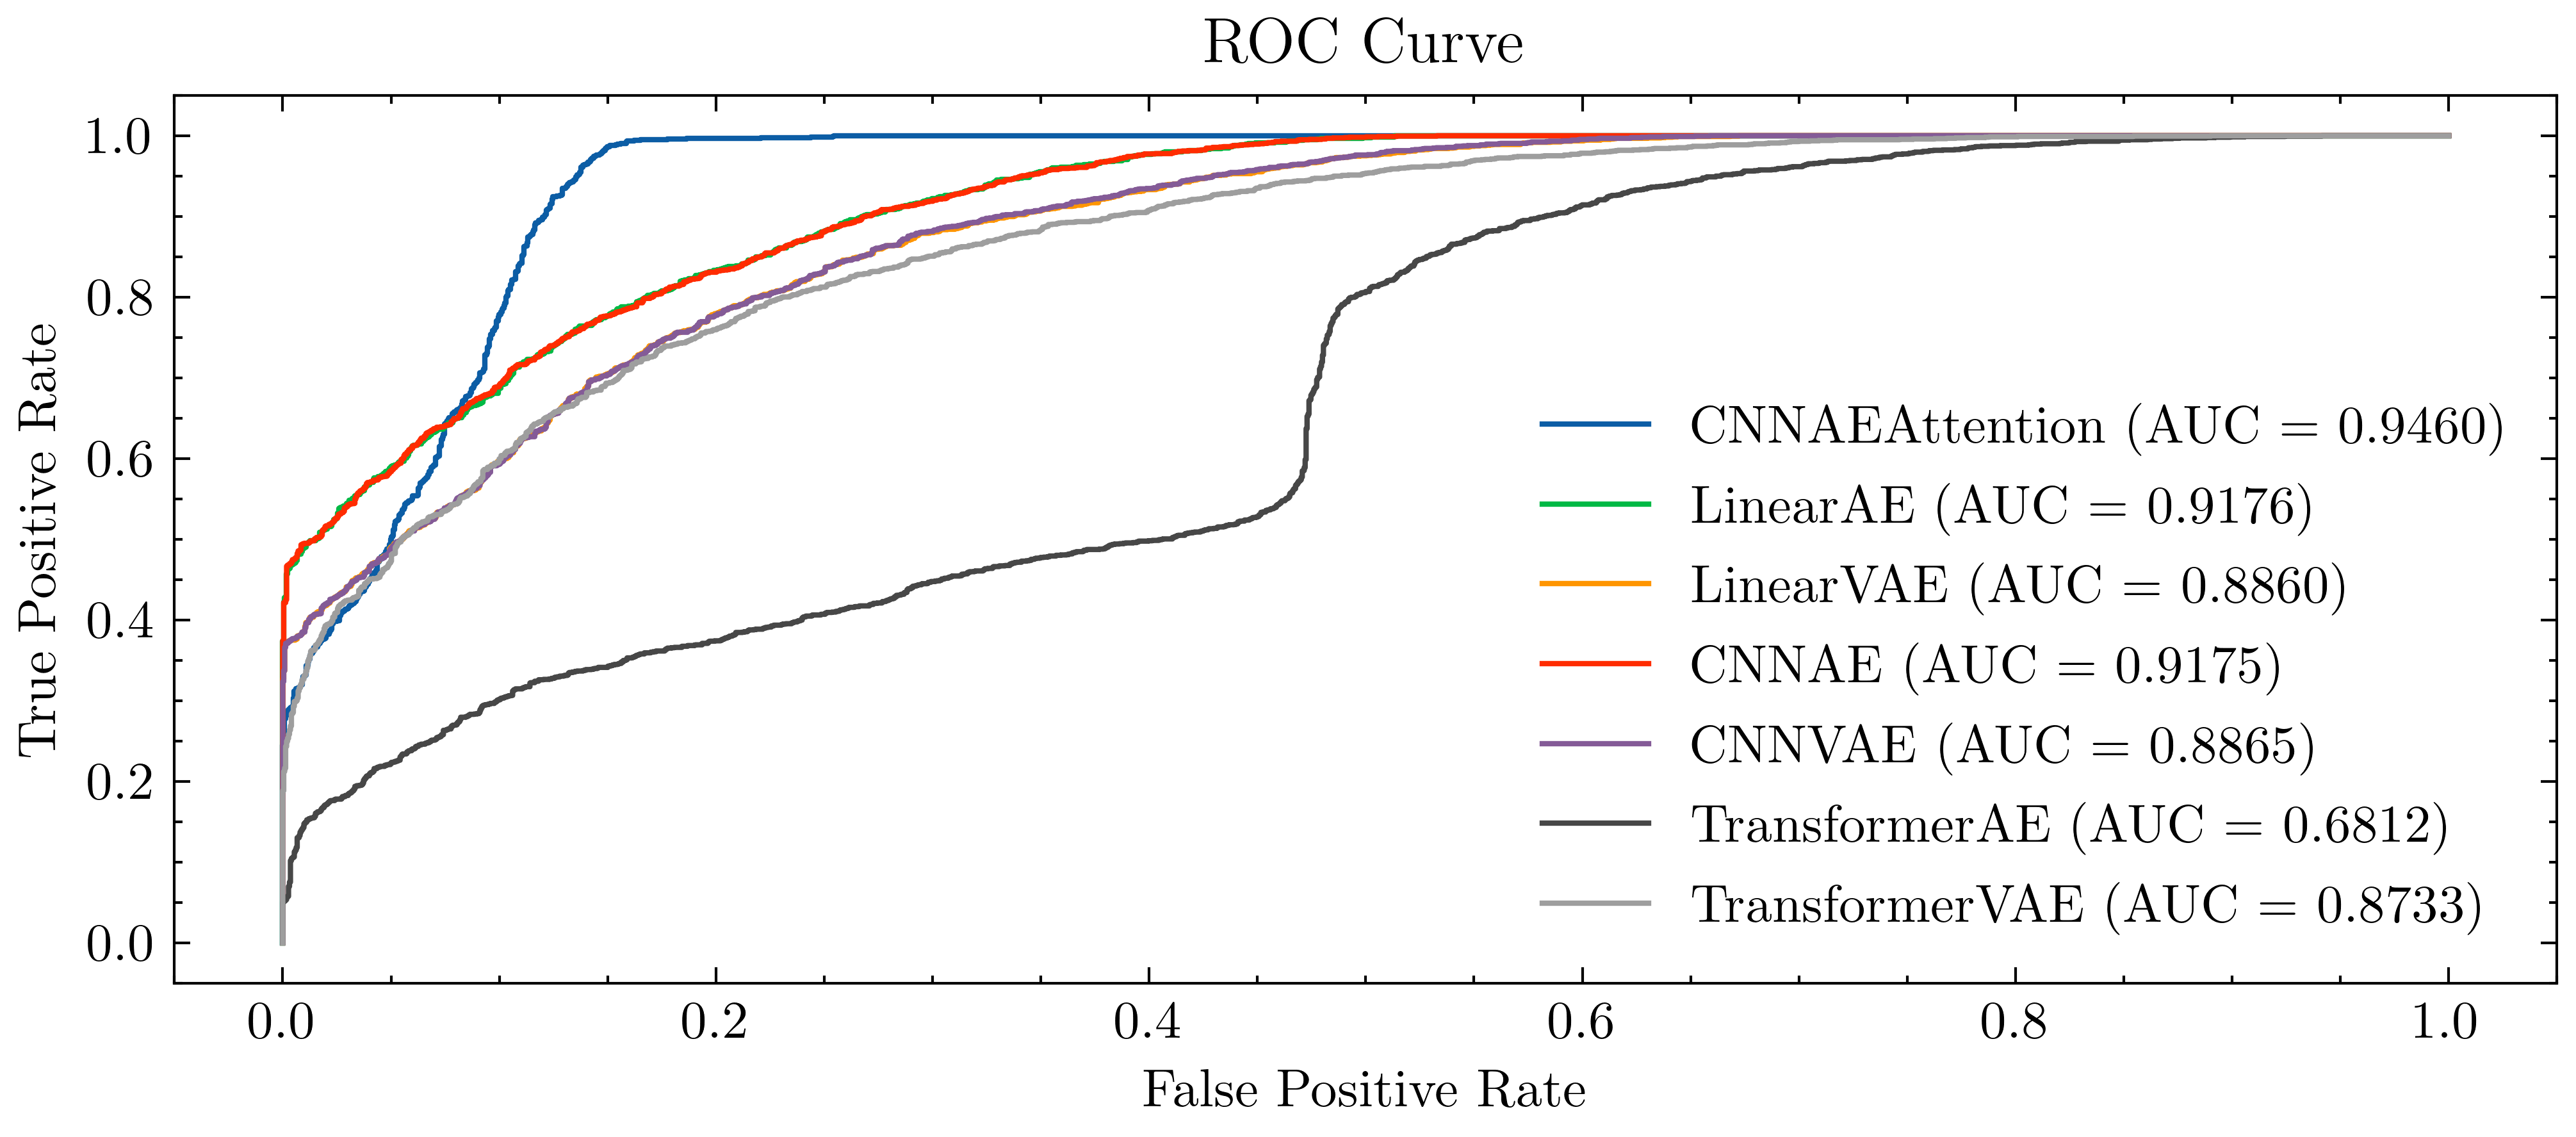

In [7]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    plt.figure(figsize=(8, 3), dpi=600)
    for model_name, metrics in results.items():
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.4f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
        #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    # plt.show()
    plt.savefig("doc/images/roc.pdf")


plot_comparative_roc(results)

In [8]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}, auc: {metrics['roc_auc']}, params: {metrics['num_params']}")
    print(f"{metrics['classification_report']}")

Model: CNNAEAttention, auc: 0.9459816902558913, params: 85026
                   precision    recall  f1-score   support

Interference-free   0.761372  0.906750  0.827726      2252
     Interference   0.882550  0.711452  0.787818      2218

         accuracy                       0.809843      4470
        macro avg   0.821961  0.809101  0.807772      4470
     weighted avg   0.821500  0.809843  0.807924      4470

Model: LinearAE, auc: 0.9175516963580714, params: 4200384
                   precision    recall  f1-score   support

Interference-free   0.752051  0.895648  0.817592      2252
     Interference   0.868568  0.700180  0.775337      2218

         accuracy                       0.798658      4470
        macro avg   0.810309  0.797914  0.796465      4470
     weighted avg   0.809866  0.798658  0.796625      4470

Model: LinearVAE, auc: 0.8860481896064334, params: 2429504
                   precision    recall  f1-score   support

Interference-free   0.728934  0.868117  0.79246

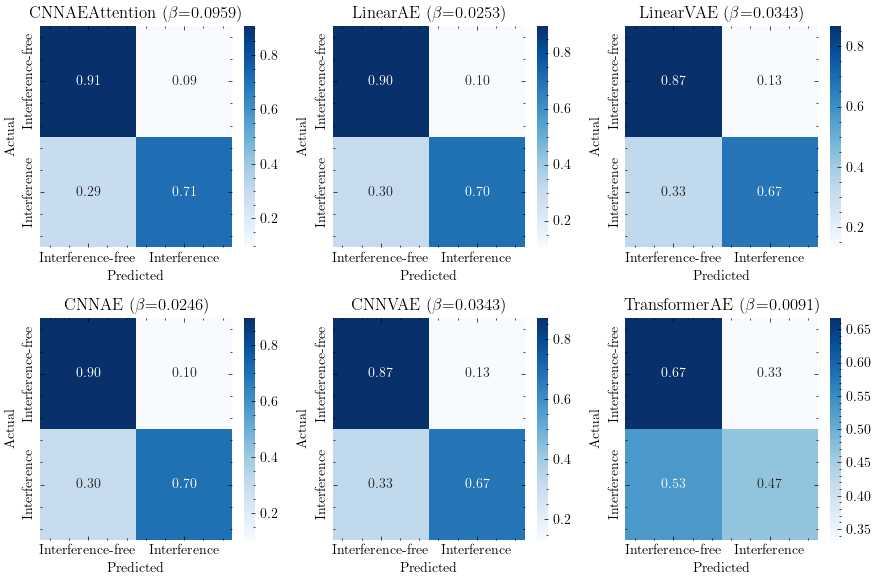

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    num_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 2x3 grid

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for ax, (model_name, metrics) in zip(axes, results.items()):
        cm = metrics['confusion_matrix']

        if normalize:
            # Normalize by row (true class)
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'], ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{model_name} ($\\beta$={metrics["threshold"]:.4f})')
        ax.xaxis.set_tick_params(rotation=0)
        
    # Hide unused subplots
    for i in range(num_models, 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("doc/images/confusion.pdf", bbox_inches='tight', dpi=600)


# Example usage:
plot_comparative_confusion_matrices(results)